In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from seaborn import heatmap

In [2]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')

bidsroot = os.path.join(project_dir, 'data_denoised')
deriv_dir = os.path.join(bidsroot, 'derivatives')
fmriprep_dir = os.path.join(deriv_dir, 'denoised_fmriprep-22.1.1')

beh_out_dir = os.path.join(deriv_dir, 'behavior')

task_list = ['tonecat']
task_label = task_list[0]

In [3]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27',
               'sub-FLT07', # bad QA 11/14/23
               'sub-FLT02', # missing resp_6 in run00 (pressing wrong keys)
               #'sub-FLT10', # MISSING 11/16/23
               #'sub-FLT01', 'sub-FLT16',  
               #'sub-FLT19', 'sub-FLT20',
               #'sub-FLT28', 'sub-FLT30',
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [4]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])
sub_dict = {'Mandarin': sub_list_mand, 'non-Mandarin': sub_list_nman}
sub_list_all = sub_list_mand + sub_list_nman

In [5]:
tone_labels = ['T1', 'T2', 'T3', 'T4']

# Accuracy and reaction time

In [6]:
run_acc_dict = {}
run_rt_dict = {}

run_df_list = []
for rx, run in enumerate(range(6)):
    group_acc_list = []
    group_rt_list = []
    
    group_resp1_list = []
    group_resp2_list = []
    group_resp3_list = []
    group_resp4_list = []
    
    sub_list = []
    for sub_id in sub_list_nman:
        sub_list.append(sub_id)
        bids_dir = os.path.join(bidsroot, sub_id, 'func')

        #bids_tsv_list = sorted(glob(bids_dir+f'/*task-{task_label}*events.tsv'))

        run_tsv = glob(bids_dir+f'/*task-{task_label}_run-0{rx+1}*events.tsv')[0]
        tsv_pd = pd.read_csv(run_tsv, sep='\t')

        tsv_pd = tsv_pd[~tsv_pd['trial_type'].str.contains('resp_None')]


        simple_df = tsv_pd.loc[:,['trial_type', 'correct_key', 'response_time']].dropna()
        simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]

        simple_df['correct_key'] = simple_df['correct_key'].astype(int).astype(str)

        simple_df['trial_type'] = [x[-1] for x in simple_df['trial_type']]

        renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                        ['1', '2', '3', '4'])

        run_rt = renum_simple_df.response_time.astype(float).mean()
        #print(run_rt)

        ncor = len(renum_simple_df.query('trial_type == correct_key'))
        ninc = len(renum_simple_df.query('trial_type != correct_key'))
        ntrials = ncor+ninc

        run_acc = ncor / ntrials
        #print(run_acc)
        
        group_acc_list.append(run_acc)
        group_rt_list.append(run_rt)
        
        # get response counts
        group_resp1_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['1'])
        group_resp2_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['2'])
        group_resp3_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['3'])
        group_resp4_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['4'])
    
    # older approach
    #run_acc_dict[f'run-0{rx+1}'] = group_acc_list
    #run_rt_dict[f'run-0{rx+1}'] = group_rt_list    
    
    # combine results and info into run-specific dataframe
    run_df = pd.DataFrame(columns=['Participant_ID', 'Run', 'Accuracy', 'RT (s)'])
    run_df['Participant_ID'] = sub_list
    run_df['Run'] = f'run-0{rx+1}'
    run_df['Accuracy'] = group_acc_list
    run_df['RT (s)'] = group_rt_list
    
    # add response summaries to dataframe
    run_df['count_resp-1'] = group_resp1_list
    run_df['count_resp-2'] = group_resp2_list
    run_df['count_resp-3'] = group_resp3_list
    run_df['count_resp-4'] = group_resp4_list
    
    resp_df = pd.DataFrame()
    for resp in ['1', '2', '3', '4']:
        resp_df[f'resp-{resp}'] = renum_simple_df.groupby('trial_type')['response_time'].count().loc[str(resp)]
    
    # append to list of dataframes across runs
    run_df_list.append(run_df)

/scratch/slurm-3865294/ipykernel_50009/1465665506.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/1465665506.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/1465665506.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/1465665506.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/1465665506.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.conta

In [7]:
run_df

,Participant_ID,Run,Accuracy,RT (s),count_resp-1,count_resp-2,count_resp-3,count_resp-4
0,sub-FLT04,run-06,0.729167,1.300266,19,8,14,7
1,sub-FLT06,run-06,0.895833,1.036703,12,13,9,14
2,sub-FLT09,run-06,0.812500,1.099691,16,11,11,10
3,sub-FLT11,run-06,0.872340,1.013764,9,11,11,16
4,sub-FLT12,run-06,0.936170,1.116703,12,12,11,12
5,sub-FLT13,run-06,0.893617,1.087650,13,12,9,13
6,sub-FLT14,run-06,0.979167,1.035730,12,13,11,12
7,sub-FLT20,run-06,0.847826,1.093342,15,12,11,8
8,sub-FLT25,run-06,0.347826,1.242382,6,22,9,9
9,sub-FLT28,run-06,0.622222,1.233109,8,13,10,14


In [8]:
behav_df = pd.concat(run_df_list)
print(behav_df)

   Participant_ID     Run  Accuracy    RT (s)  count_resp-1  count_resp-2  \
0       sub-FLT04  run-01  0.333333  1.300002            18            12   
1       sub-FLT06  run-01  0.255814  1.189587            13             6   
2       sub-FLT09  run-01  0.288889  1.341544            13            16   
3       sub-FLT11  run-01  0.217391  1.281659             9            13   
4       sub-FLT12  run-01  0.933333  1.166794            11            10   
..            ...     ...       ...       ...           ...           ...   
6       sub-FLT14  run-06  0.979167  1.035730            12            13   
7       sub-FLT20  run-06  0.847826  1.093342            15            12   
8       sub-FLT25  run-06  0.347826  1.242382             6            22   
9       sub-FLT28  run-06  0.622222  1.233109             8            13   
10      sub-FLT30  run-06  0.979167  1.039144            13            12   

    count_resp-3  count_resp-4  
0              8             7  
1        

In [9]:
# save behavioral summary file
fname = 'FLT_behav_summary.csv'
behav_df.to_csv(fname)

### Statistics

In [12]:
from scipy import stats

In [22]:
data1 = behav_df.where(behav_df.Run=='run-01').dropna()['Accuracy']
data2 = behav_df.where(behav_df.Run=='run-06').dropna()['Accuracy']

res = stats.ttest_rel(data2, data1)
print('Accuracy')
print(f't = {res.statistic:.02f}; p = {res.pvalue:.04f}')

data1 = behav_df.where(behav_df.Run=='run-01').dropna()['RT (s)']
data2 = behav_df.where(behav_df.Run=='run-06').dropna()['RT (s)']

res = stats.ttest_rel(data2, data1)
print('RT (s)')
print(f't = {res.statistic:.02f}; p = {res.pvalue:.04f}')


Accuracy
t = 6.01; p = 0.0001
RT (s)
t = -3.15; p = 0.0103


### Plot accuracy and RT

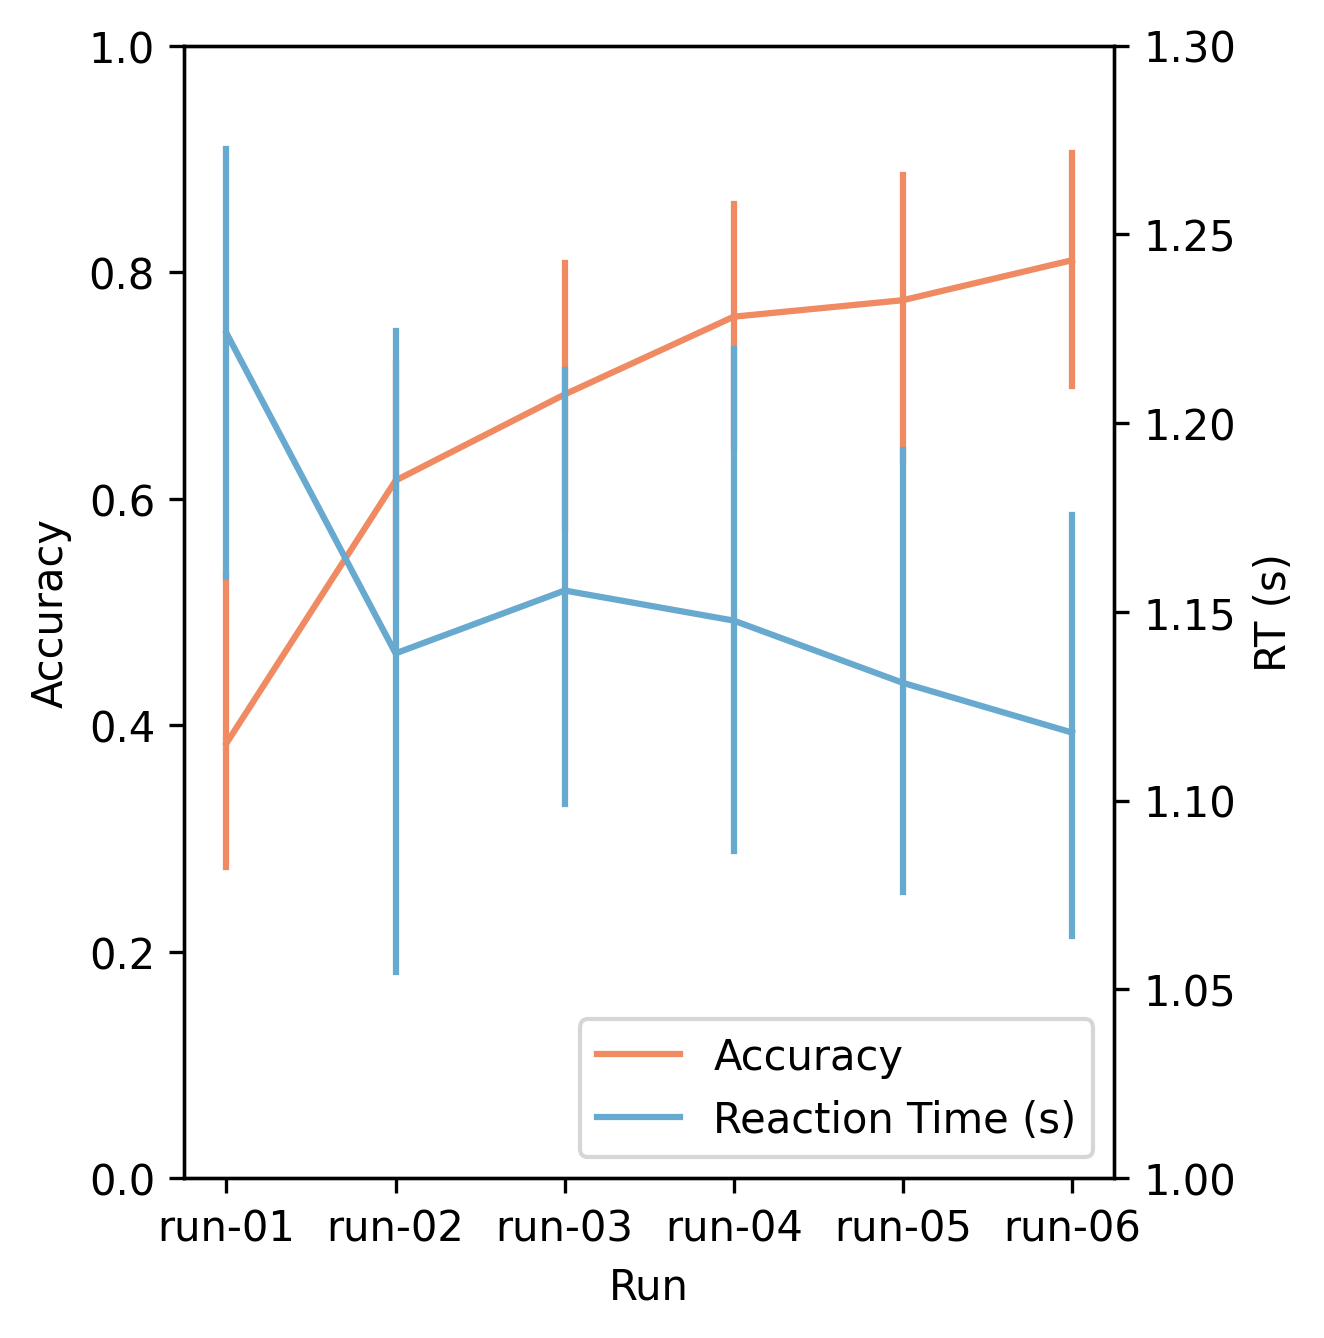

In [10]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4,5), dpi=300)
sns.lineplot(behav_df, x='Run', y='Accuracy', color='#ef8a62', err_style='bars', ax=ax)
ax.set_ylim([0, 1])
ax2 = ax.twinx()
sns.lineplot(behav_df, x='Run', y='RT (s)', color='#67a9cf', err_style='bars', ax=ax2)
ax2.set_ylim([1, 1.3])
ax.legend(loc="lower right",
          handles=[Line2D([], [], marker='_', color="#ef8a62", label='Accuracy'), 
                   Line2D([], [], marker='_', color="#67a9cf", label='Reaction Time (s)')])


#### Include individual lineplots

/scratch/slurm-3865294/ipykernel_50009/2309788476.py:5: UserWarning: The palette list has more values (12) than needed (11), which may not be intended.
  sns.lineplot(behav_df, x='Run', y='Accuracy',
/scratch/slurm-3865294/ipykernel_50009/2309788476.py:16: UserWarning: The palette list has more values (12) than needed (11), which may not be intended.
  sns.lineplot(behav_df, x='Run', y='RT (s)',


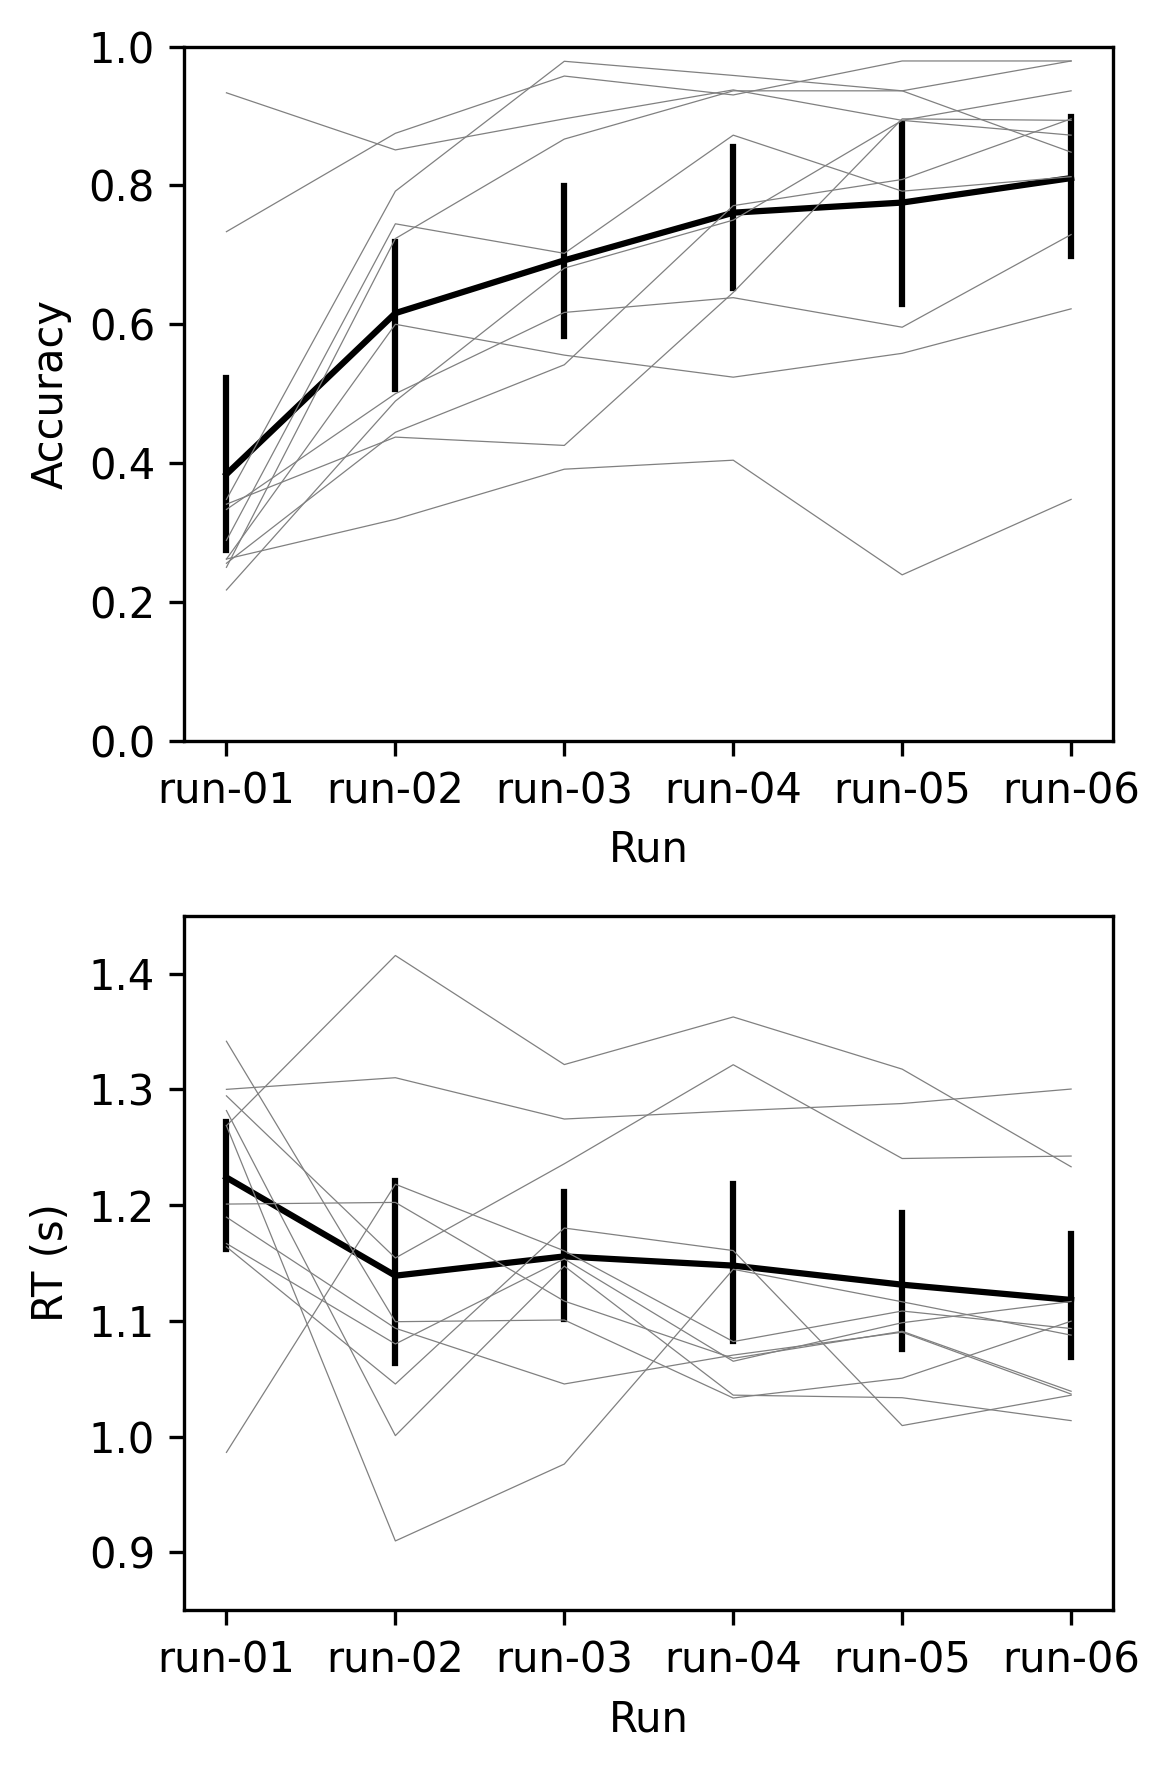

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), dpi=300)
sns.lineplot(behav_df, x='Run', y='Accuracy', 
             color='black', err_style='bars', 
             ax=ax[0])
sns.lineplot(behav_df, x='Run', y='Accuracy', 
             hue='Participant_ID', 
             palette=sns.color_palette(['grey'], 12),
             linewidth=0.3,
             ax=ax[0],
             legend=None)
ax[0].set_ylim([0, 1])

sns.lineplot(behav_df, x='Run', y='RT (s)', 
             color='black', err_style='bars', 
             ax=ax[1])
sns.lineplot(behav_df, x='Run', y='RT (s)', 
             hue='Participant_ID', 
             palette=sns.color_palette(['grey'], 12),
             linewidth=0.3,
             ax=ax[1],
             legend=None)
ax[1].set_ylim([0.85, 1.45])

fig.tight_layout()
fig.savefig('behav_acc_rt.svg')

# Response RDMs

In [23]:
run_cm_dict = {}
for rx, run in enumerate(range(6)):
    group_cm_list = []
    for sub_id in sub_list_nman:
        bids_dir = os.path.join(bidsroot, sub_id, 'func')

        #bids_tsv_list = sorted(glob(bids_dir+f'/*task-{task_label}*events.tsv'))

        run_tsv = glob(bids_dir+f'/*task-{task_label}_run-0{rx+1}*events.tsv')[0]
        tsv_pd = pd.read_csv(run_tsv, sep='\t')

        tsv_pd = tsv_pd[~tsv_pd['trial_type'].str.contains('resp_None')]

        simple_df = tsv_pd.loc[:,['trial_type', 'correct_key']].dropna()
        simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]

        simple_df['correct_key'] = simple_df['correct_key'].astype(int).astype(str)

        simple_df['trial_type'] = [x[-1] for x in simple_df['trial_type']]

        renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                        ['1', '2', '3', '4'])

        cm = confusion_matrix(renum_simple_df['correct_key'], renum_simple_df['trial_type'], normalize='true')

        group_cm_list.append(cm)
    run_cm_dict[f'run-0{rx+1}'] = group_cm_list

/scratch/slurm-3865294/ipykernel_50009/2659819552.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/2659819552.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/2659819552.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/2659819552.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]
/scratch/slurm-3865294/ipykernel_50009/2659819552.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.conta

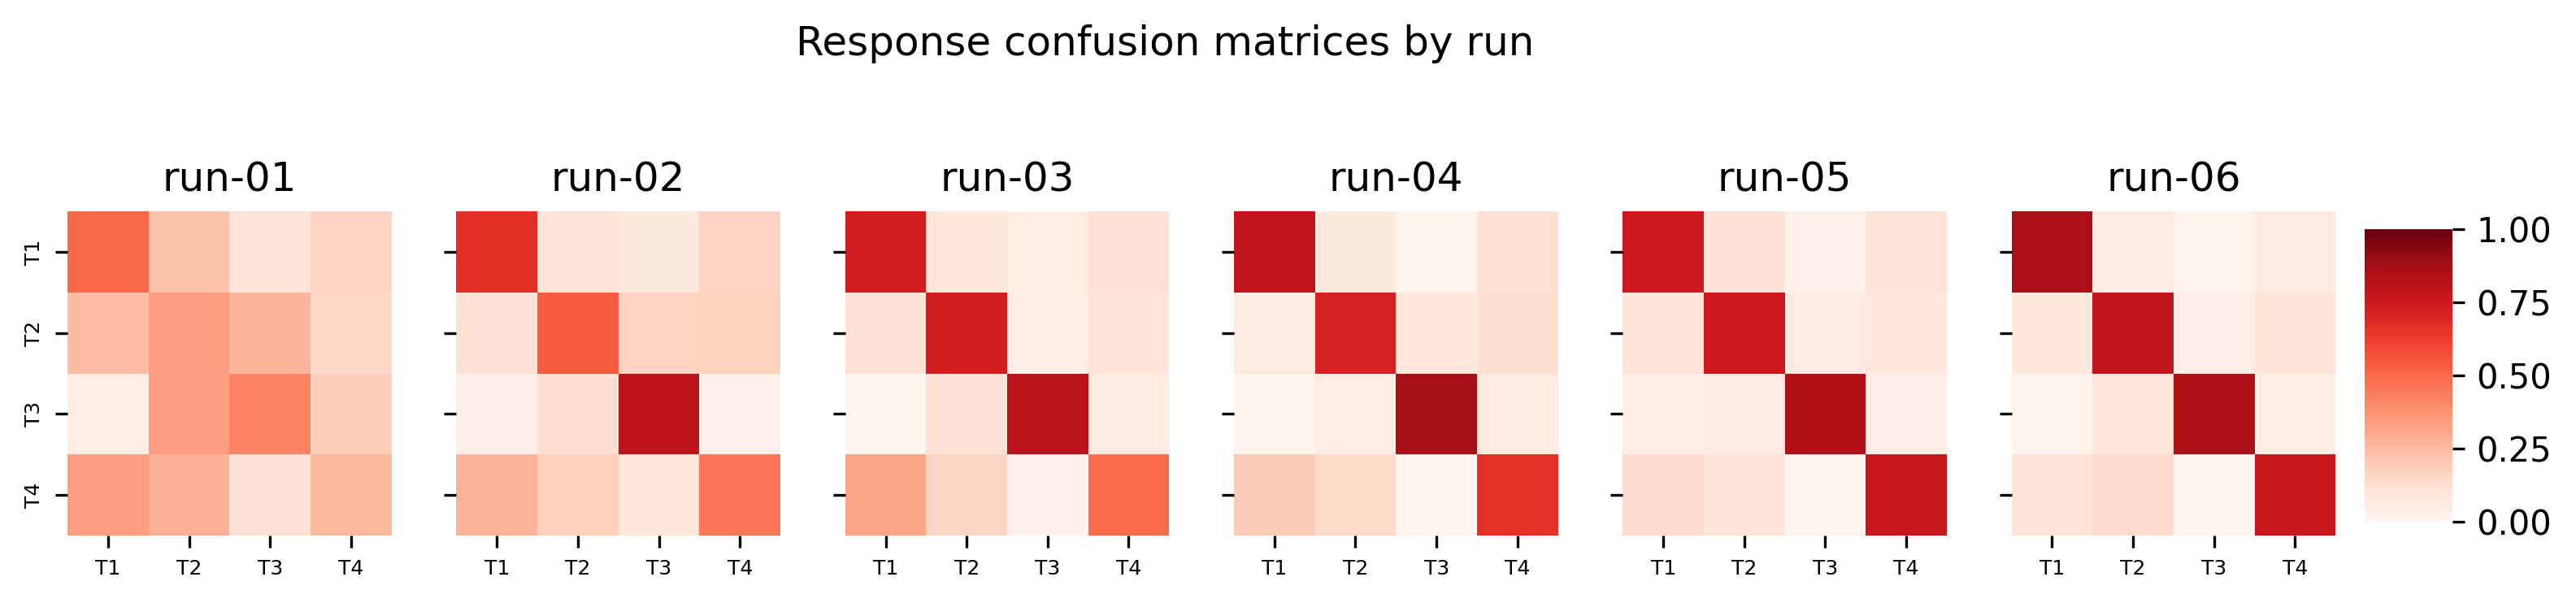

In [39]:
fig,ax = plt.subplots(1,6, figsize=(12,3), dpi=300, sharey=True)
fig.suptitle('Response confusion matrices by run')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for rx, run_id in enumerate(run_cm_dict):
    #print(run_id)
    run_mean = np.mean(run_cm_dict[run_id], axis=0)
    
    sns.heatmap(run_mean, 
                square=True,
                cmap='Reds',
                ax=ax[rx],
                cbar=True, cbar_ax=cbar_ax,
                annot=False,
                vmin=0, 
                vmax=1,
                xticklabels=tone_labels,
                yticklabels=tone_labels,
                ) 
    ax[rx].set_title(run_id)
    ax[rx].tick_params(labelsize=6)

#fig.tight_layout()
fig.savefig('cm_response.svg')

### Test (single subject) simple tone confusion matrix

In [27]:
sub_id = sub_list_nman[0]
bids_dir = os.path.join(bidsroot, sub_id, 'func')

bids_tsv_list = sorted(glob(bids_dir+f'/*task-{task_label}*events.tsv'))

run_tsv = bids_tsv_list[0]
tsv_pd = pd.read_csv(run_tsv, sep='\t')

tsv_pd = tsv_pd[~tsv_pd['trial_type'].str.contains('resp_None')]

run_id = os.path.basename(run_tsv).split('_')[2]
print(run_id)

run-01


In [28]:
simple_df = tsv_pd.loc[:,['trial_type', 'correct_key']].dropna()
simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]

simple_df['correct_key'] = simple_df['correct_key'].astype(int).astype(str)

simple_df['trial_type'] = [x[-1] for x in simple_df['trial_type']]

renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                ['1', '2', '3', '4'])

/scratch/slurm-3865294/ipykernel_50009/1558107547.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]


In [29]:
tsv_pd

,Unnamed: 0,onset,duration,trial_type,stim_file,response_time,correct_key
0,0,2.500000,0.300000,sound_di2-bN,stimuli/di2-bN_48000Hz_pol2_S15filt.wav,NaN,NaN
1,1,3.663832,0.500000,resp_7,NaN,1.163832,6.0
2,2,6.179814,0.749494,fb_wrong,NaN,NaN,NaN
3,3,8.510745,0.300000,sound_di4-bN,stimuli/di4-bN_48000Hz_pol2_S15filt.wav,NaN,NaN
4,4,9.912417,0.500000,resp_7,NaN,1.401673,2.0
...,...,...,...,...,...,...,...
136,136,345.687065,0.500000,resp_2,NaN,1.824419,2.0
137,137,346.527065,0.748676,fb_correct,NaN,NaN,NaN
138,138,355.834679,0.300000,sound_di4-iN,stimuli/di4-iN_48000Hz_pol2_S15filt.wav,NaN,NaN
139,139,357.354136,0.500000,resp_6,NaN,1.519457,2.0


In [30]:
cm = confusion_matrix(renum_simple_df['correct_key'], renum_simple_df['trial_type'], normalize='true')
#np.savetxt('behav_confusion_matrices/sub-{}_tonecat_confusion_matrix.csv'.format(sub_id), cm)

'''
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay.from_predictions(renum_simple_df['correct_key'], renum_simple_df['trial_type'],  
                                               ax=ax,
                                               display_labels=['T1', 'T2', 'T3', 'T4'],
                                               cmap='Blues', colorbar=False, include_values=False,)
ax.set_title(sub_id)
#fig.savefig('behav_confusion_matrices/sub-{}_behav_confusion_matrix.png'.format(sub_id))
'''
print('sub-{} {} accuracy = {:.03f}'.format(sub_id, run_id, cm.diagonal().mean()))

sub-sub-FLT04 run-01 accuracy = 0.319


<AxesSubplot: >

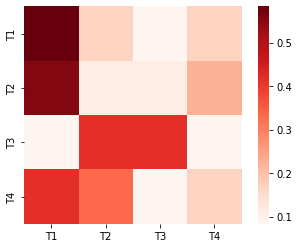

In [31]:
sns.heatmap(cm, 
            square=True,
            cmap='Reds',
            cbar=True,
            xticklabels=tone_labels,
            yticklabels=tone_labels,
            ) 

# Behavioral RDMs

from Feng et al. (*NoL*):
> Learners’ response confusion matrices were created based on their categorization responses. If two sounds had an identical response, then this pair was coded as 0 in the confusion matrix; otherwise, it was coded as 1. Using this procedure, we created two confusion matrices in each block (one for each talker) for each learner. The two matrices were then averaged for each block. Finally, we calculated the Spearman’ s correlations (i.e., model fits) between each RDM and confusion matrices. We also examined the relationships between the RDM model fits and learning outcome and speed across subjects to see which RDM explains most of the interindividual variance in learning success.

In [32]:
stim_df = tsv_pd.loc[:,['trial_type', 'correct_key']]

# create a `stimulus` row
stim_df['stimulus'] = ''

# copy stimulus info to the response rows
for ix in range(1, len(stim_df)):
    if 'resp' in stim_df['trial_type'][ix]:
        stim_df['stimulus'].iloc[ix] = stim_df['trial_type'].iloc[ix-1].split('_')[1]

# clean up the behavioral dataframe
stim_df.dropna(inplace=True)

# label the responses based on the feedback presented next
stim_df['trial_type'] = [x[-1] for x in stim_df['trial_type']]

# replace button press labels (from the MRI button boxes) with tone labels
stim_df['trial_type'] = stim_df['trial_type'].astype(str).replace(['7', '6', '1', '2'], 
                                                                  ['1', '2', '3', '4'])

stim_df['correct_key'] = stim_df['correct_key'].replace([7.0, 6.0, 1.0, 2.0], 
                                                        ['1', '2', '3', '4'])

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## compare responses across stimuli

In [25]:
stim_list = np.unique(stim_df[stim_df['stimulus'].str.contains('di')]['stimulus'])

# extract responses for each stimulus
all_stim_responses = []
for sx, stim in enumerate(stim_list):
    stim_responses = []
    for block in range(3):
        try:
            stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])
        except:
            stim_responses.append(np.nan)
    all_stim_responses.append(stim_responses)

/scratch/slurm-3865294/ipykernel_50009/3388081672.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])


In [26]:
# compare responses across stimuli
n_stim = len(all_stim_responses)
stim_conf_mat = np.zeros((n_stim, n_stim))
for srx in range(n_stim):
    for sry in range(n_stim):
        mean_val = np.mean([int(all_stim_responses[srx][x] == all_stim_responses[sry][x]) for x in range(3)])
        stim_conf_mat[srx, sry] = mean_val

# save output matrix
sub_beh_out_dir = os.path.join(beh_out_dir, sub_id)
os.makedirs(sub_beh_out_dir, exist_ok=True)
sub_run_out_fpath = os.path.join(sub_beh_out_dir, 
                                 f'{sub_id}_{run_id}_stimulus_confusion_matrix.tsv')
np.savetxt(sub_run_out_fpath, stim_conf_mat, delimiter='\t')

NameError: name 'run_id' is not defined

<AxesSubplot: >

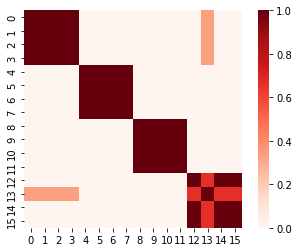

In [43]:
sns.heatmap(stim_conf_mat, 
            square=True,
            cmap='Reds')

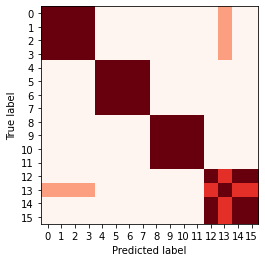

In [44]:
ConfusionMatrixDisplay(stim_conf_mat).plot(#ax=ax, 
                                           colorbar=False, 
                                           im_kw={'cmap':'Reds', },
                                           include_values=False,
                                           )

# Group analyses

After generating single-subject, single-run confusion matrices via `create_behav_confusion_matrices.py`

## Non-Mandarin speaking participants

In [36]:
run_cm_dict = {}
for rx, run in enumerate(range(6)):
    run_cm_list = []
    for smx, sub_id in enumerate(sub_list_nman):
        sub_beh_dir = os.path.join(deriv_dir, 'behavior', sub_id)
        sub_stim_cm_list = []

        sub_run_stim_cm = np.genfromtxt(os.path.join(sub_beh_dir, f'{sub_id}_run-0{rx+1}_stimulus_confusion_matrix.tsv'))
        run_cm_list.append(sub_run_stim_cm)
    run_cm_dict[f'run-0{run+1}'] = run_cm_list

In [37]:
stim_labels = ['di1_aN', 'di1_bN', 'di1_hN', 'di1_iN', 
               'di2_aN', 'di2_bN', 'di2_hN', 'di2_iN', 
               'di3_aN', 'di3_bN', 'di3_hN', 'di3_iN', 
               'di4_aN', 'di4_bN', 'di4_hN', 'di4_iN', ]

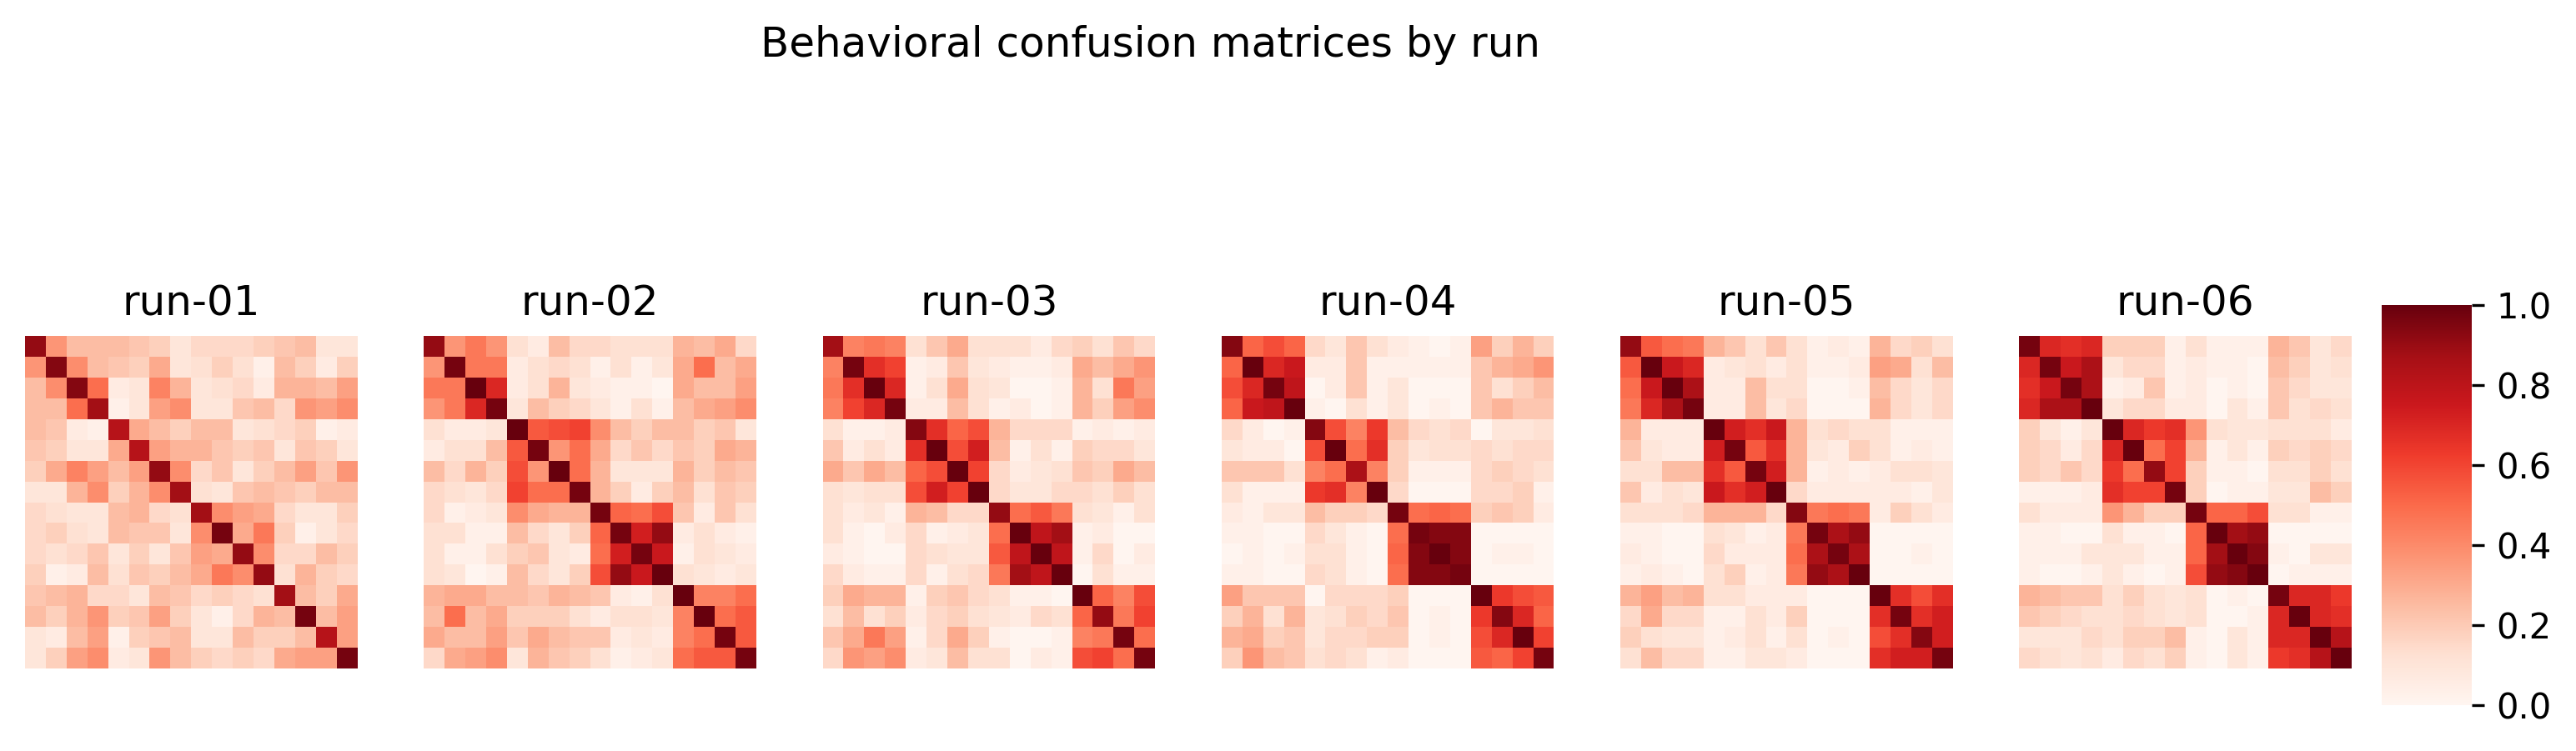

In [38]:
fig,ax = plt.subplots(1,6, figsize=(12,4), dpi=300, sharey=True)
fig.suptitle('Behavioral confusion matrices by run')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for rx, run_id in enumerate(run_cm_dict):
    #print(run_id)
    run_mean = np.mean(run_cm_dict[run_id], axis=0)
    
    sns.heatmap(run_mean, 
                square=True,
                cmap='Reds',
                vmin=0, vmax=1,
                ax=ax[rx],
                cbar=True, cbar_ax = cbar_ax,
                xticklabels=False, #stim_labels,
                yticklabels=False, #stim_labels,
                ) 
    ax[rx].set_title(run_id)
    ax[rx].tick_params(labelsize=6)
    #ax[rx].set_xticklabels(ax[rx].get_xticklabels(), rotation=60, ha='right');

#fig.tight_layout()
fig.savefig('cm_behavior.svg')

## Mandarin speaking participants

In [14]:
run_cm_dict = {}
for rx, run in enumerate(range(6)):
    run_cm_list = []
    for smx, sub_id in enumerate(sub_list_mand):
        sub_beh_dir = os.path.join(deriv_dir, 'behavior', sub_id)
        sub_stim_cm_list = []

        sub_run_stim_cm = np.genfromtxt(os.path.join(sub_beh_dir, f'{sub_id}_run-0{rx+1}_stimulus_confusion_matrix.tsv'))
        run_cm_list.append(sub_run_stim_cm)
    run_cm_dict[f'run0{run+1}'] = run_cm_list

In [15]:
stim_labels = ['di1_aN', 'di1_bN', 'di1_hN', 'di1_iN', 
               'di2_aN', 'di2_bN', 'di2_hN', 'di2_iN', 
               'di3_aN', 'di3_bN', 'di3_hN', 'di3_iN', 
               'di4_aN', 'di4_bN', 'di4_hN', 'di4_iN', ]

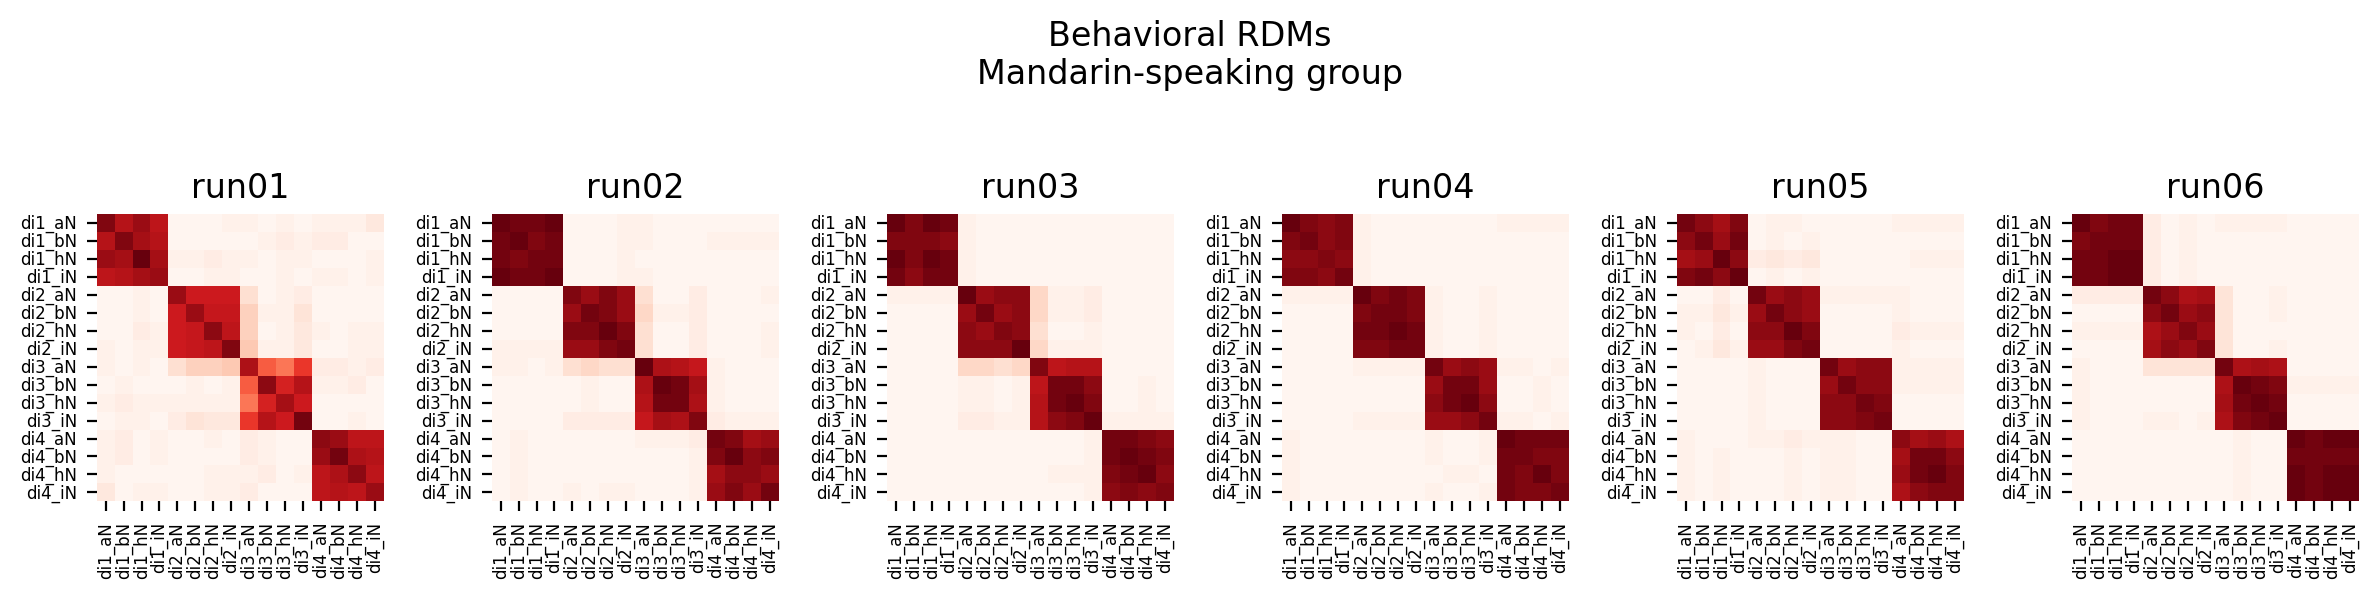

In [16]:
fig,ax = plt.subplots(1,6, figsize=(12,3), dpi=200)
fig.suptitle('Behavioral RDMs\nMandarin-speaking group')

for rx, run_id in enumerate(run_cm_dict):
    #print(run_id)
    run_mean = np.mean(run_cm_dict[run_id], axis=0)
    
    sns.heatmap(run_mean, 
                square=True,
                cmap='Reds',
                ax=ax[rx],
                cbar=False,
                xticklabels=stim_labels,
                yticklabels=stim_labels,
                ) 
    ax[rx].set_title(run_id)
    ax[rx].tick_params(labelsize=6)

fig.tight_layout()

# ARCHIVE: Original analysis on direct psychopy log files (not BIDS-ified)

Ah! But my bids-converted events files don't include the actual button responses and what the expected correct response would be. Gotta go back to the source data....

In [3]:
raw_beh_dir = os.path.join('/bgfs/bchandrasekaran/krs228/',
                           'data/FLT/sourcedata/behav_files/',
                           'CHA-IBR/01-ToneLearning')

sub-FLT01 accuracy = 0.990
sub-FLT03 accuracy = 0.960
sub-FLT05 accuracy = 0.967
sub-FLT07 accuracy = 1.000
sub-FLT08 accuracy = 1.000
sub-FLT10 accuracy = 0.982
sub-FLT02 accuracy = 0.863
sub-FLT04 accuracy = 0.584
sub-FLT06 accuracy = 0.613
sub-FLT09 accuracy = 0.654
sub-FLT11 accuracy = 0.628
sub-FLT12 accuracy = 0.899
sub-FLT13 accuracy = 0.623


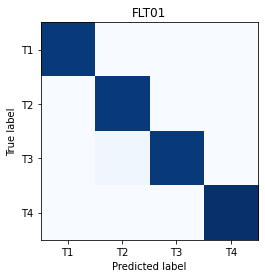

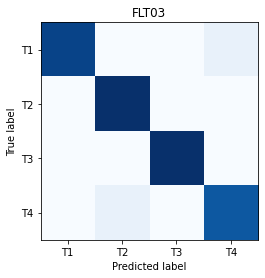

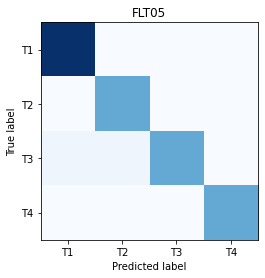

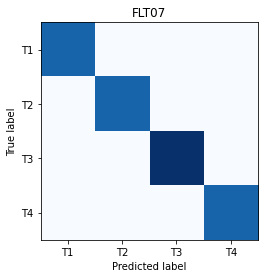

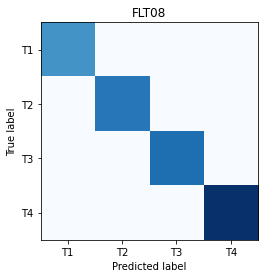

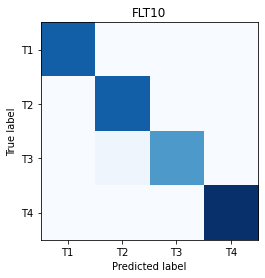

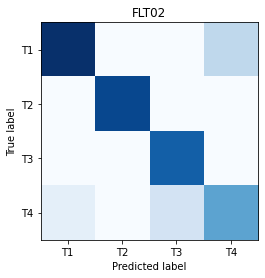

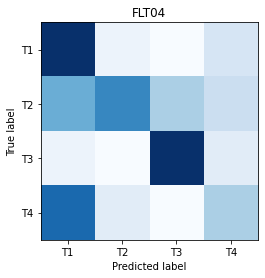

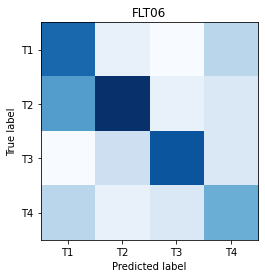

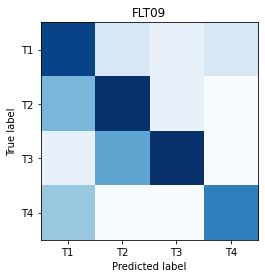

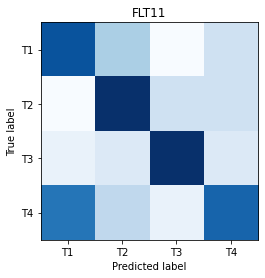

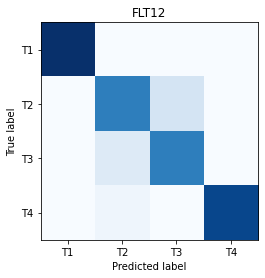

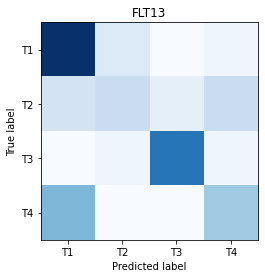

In [4]:
for sub_id in sub_list:
    file_list = sorted(glob(raw_beh_dir+'/sub-{}*tone_learning*.csv'.format(sub_id)))
    psy_list = []
    for rx, fpath in enumerate(file_list):
        psy_df = pd.read_csv(fpath, sep=',')

        psy_list.append(psy_df)
    all_df = pd.concat(psy_list)

    # just keep the critical data columns
    simple_df = all_df.loc[:,['key_resp.keys', 'corrAns']].dropna()

    simple_df['corrAns'] = simple_df['corrAns'].astype(int)

    renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                    ['1', '2', '3', '4'])

    renum_simple_df.drop(renum_simple_df[renum_simple_df['key_resp.keys']=='None'].index, inplace=True)
    renum_simple_df.drop(renum_simple_df[renum_simple_df['key_resp.keys']=='8'].index, inplace=True)
    renum_simple_df.drop(renum_simple_df[renum_simple_df['corrAns']=='0'].index, inplace=True)

    y_correct = np.array(renum_simple_df['corrAns'])
    y_response = np.array(renum_simple_df['key_resp.keys'])   

    cm = confusion_matrix(y_correct, y_response, normalize='true')
    #np.savetxt('behav_confusion_matrices/sub-{}_behav_confusion_matrix.csv'.format(sub_id), cm)

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_correct, y_response,  ax=ax,
                                                   display_labels=['T1', 'T2', 'T3', 'T4'],
                                                   cmap='Blues', colorbar=False, include_values=False,)
    ax.set_title(sub_id)
    #fig.savefig('behav_confusion_matrices/sub-{}_behav_confusion_matrix.png'.format(sub_id))
    print('sub-{} accuracy = {:.03f}'.format(sub_id, cm.diagonal().mean()))

In [5]:
cm

array([[0.84615385, 0.11538462, 0.        , 0.03846154],
       [0.25      , 0.3125    , 0.125     , 0.3125    ],
       [0.        , 0.05555556, 0.88888889, 0.05555556],
       [0.55555556, 0.        , 0.        , 0.44444444]])

In [54]:
renum_simple_df['corrAns'].unique()

array(['4', '0', '3', '1', '2'], dtype=object)